<a href="https://colab.research.google.com/github/arnav39/d2el-en/blob/main/8_6_Residual_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8.6 : Reisdual Networks

In [1]:
!pip install matplotlib_inline
!pip install --upgrade d2l==1.0.0a0

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l

In [3]:
a = torch.rand(6, 28, 28)
b = torch.rand(1, 28, 28)
c = a + b # b is broadcasted along all the channels

In [8]:
a1 = torch.randn(16, 14, 14)
a2 = torch.randn(16, 28, 28)
a_sum = a1 + a2
print(a_sum.shape)

RuntimeError: ignored

In [3]:
class Residual(nn.Module):

  def __init__(self, num_channels, use_1x1conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
    self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)

    if use_1x1conv:
      self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.LazyBatchNorm2d()
    self.bn2 = nn.LazyBatchNorm2d()

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3 is not None:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

In [7]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 3, 6, 6])

In [9]:
blk = Residual(6, use_1x1conv=True, strides=2)
# when we are using stirdes > 1 we will need to use 1x1 conv net to transform the input into the desired shape
X = torch.randn(4, 3, 6, 6)
blk(X).shape

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 6, 3, 3])

In [ ]:
d2l.Classifier.add_module()

In [6]:
class ResNet(d2l.Classifier):

  def __init__(self, arch, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())

    for i, b in enumerate(arch):
      self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module("last", nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                              nn.Flatten(),
                                              nn.LazyLinear(num_classes)))
    
    self.net.apply(d2l.init_cnn)


  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=7, padding=3, stride=2),
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
    )

  def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
      if i == 0 and not first_block:
        blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
      else:
        blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [14]:
arch = ((2, 64), (2, 128), (2, 256), (2, 512))

for i, a in enumerate(arch):
  print(f"i = {i}, arch[i] = {a}")

i = 0, arch[i] = (2, 64)
i = 1, arch[i] = (2, 128)
i = 2, arch[i] = (2, 256)
i = 3, arch[i] = (2, 512)


In [5]:
class ResNet18(ResNet):

  def __init__(self, lr=0.1, num_classes=10):
    arch = ((2, 64), (2, 128), (2, 256), (2, 512))
    super().__init__(arch, lr, num_classes)

  def forward(self, X):
    return self.net(X)

In [13]:
ResNet18().layer_summary((1, 1, 96, 96))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


using gpu : time = 7min

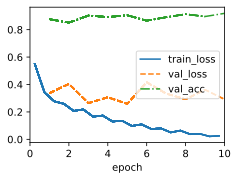

In [6]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [11]:
4.52 * 3

13.559999999999999

In [14]:
int(round(4.52 * 3))

14

In [15]:
nn.LazyConv2d??

In [17]:
3 // 4 # integer division

0

grouped convulation : 

In [32]:
nn.Conv1d??

In [37]:
import numpy as np

In [34]:
# 4 input channels, 2 groups, 2 output channels

torch.manual_seed(2022)

X = torch.randn(1, 4, 10, dtype=torch.float32)

conv_layer = nn.Conv1d(
    in_channels=4,
    out_channels=2,
    kernel_size=3,
    padding='valid',
    groups=2,
    bias=False,
    dtype=torch.float32
)

for param in conv_layer.parameters():
  param.requires_grad=False

In [35]:
X

tensor([[[-0.9788, -1.5154, -0.8222,  0.1214,  0.0716, -0.0872, -0.0253,
          -1.6267,  0.2230, -1.6746],
         [-1.4725,  0.9721, -0.2191, -0.9397, -1.7756, -0.6259, -1.1104,
           1.1890,  1.3730,  0.4915],
         [ 0.3579, -0.1685, -0.8579, -1.0574,  0.2105,  1.9045,  1.8237,
           1.5122, -0.3140, -0.0810],
         [-1.3631, -0.0701, -1.1876, -1.0787,  0.9551, -0.2958,  1.0663,
          -0.5134, -0.3846, -1.1481]]])

In [44]:
X.shape

torch.Size([1, 4, 10])

In [36]:
# since we have 4 input channels, nornmally there would have been 4 kernels per bank (total 8)
# but since we have 2 groups, each bank has 2 input channels, there would be 2 kernels per bank (total 4)

conv_layer.weight

Parameter containing:
tensor([[[-0.1461,  0.0036,  0.1194],
         [ 0.3466,  0.0458,  0.3361]],

        [[-0.0376,  0.0514,  0.2716],
         [ 0.4019,  0.1485,  0.1384]]])

In [38]:
np.correlate??

In [39]:
a = [1, 2, 3, 4, 5, 6]
v = [0, 1, 0.5]

print(np.correlate(a, v))

[3.5 5.  6.5 8. ]


In [43]:
np.squeeze??
# removes axis of length = 1 

In [42]:
X.numpy()[0][0].squeeze()

array([-0.9787663 , -1.5154158 , -0.8222357 ,  0.12136107,  0.07158673,
       -0.08717268, -0.0253445 , -1.626711  ,  0.22301038, -1.6746057 ],
      dtype=float32)

In [45]:
# now doing the operations manually

# filter bank 1 will operate on Group1

first_kernel = conv_layer.weight[0][0]
second_kernel = conv_layer.weight[0][1]

nconv1 = np.correlate(
    X.numpy()[0][0].squeeze(), # channel - 1
    first_kernel.numpy().squeeze()
)

nconv2 = np.correlate(
    X.numpy()[0][1].squeeze(), # channel - 2
    second_kernel.numpy().squeeze()
)

In [46]:
nconv1 + nconv2

array([-0.50016016,  0.2439066 , -0.5868024 , -0.64536005, -1.0311576 ,
       -0.04977366,  0.15564854,  0.6786802 ], dtype=float32)

In [47]:
# the filter bank 2 will operate on group 2

first_kernel = conv_layer.weight[1][0]
second_kernel = conv_layer.weight[1][1]

nconv1 = np.correlate(
    X.numpy()[0][2].squeeze(),
    first_kernel.squeeze()
)

nconv2 = np.correlate(
    X.numpy()[0][3].squeeze(),
    second_kernel.squeeze()
)

In [48]:
nconv1 + nconv2

array([-0.9778408 , -0.678846  , -0.4702403 ,  0.235185  ,  1.0728369 ,
        0.40115055,  0.22290531, -0.51747376], dtype=float32)

In [49]:
y = conv_layer(X)
y

tensor([[[-0.5002,  0.2439, -0.5868, -0.6454, -1.0312, -0.0498,  0.1556,
           0.6787],
         [-0.9778, -0.6788, -0.4702,  0.2352,  1.0728,  0.4012,  0.2229,
          -0.5175]]])

In [5]:
class ResNetXtBlock(nn.Module):

  def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False, strides=1):
    super().__init__()
    bot_channels = int(round(num_channels * bot_mul))
    self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1)
    self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3, padding=1, stride=strides, groups = groups)
    self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1)
    self.bn1 = nn.LazyBatchNorm2d()
    self.bn2 = nn.LazyBatchNorm2d()
    self.bn3 = nn.LazyBatchNorm2d()

    if use_1x1conv:
      self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
      self.bn4 = nn.LazyBatchNorm2d()
    else:
      self.conv4 = None

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = F.relu(self.bn2(self.conv2(Y)))
    Y = self.bn3(self.conv3(Y))

    if self.conv4 is not None:
      X = self.bn4(self.conv4(X))

    return F.relu(Y + X)

In [53]:
blk = ResNetXtBlock(num_channels=32, groups=16, bot_mul=1)
X = torch.randn(4, 32, 96, 96)
blk(X).shape

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 32, 96, 96])

In [23]:
blk = ResNetXtBlock(32, 16, 1, use_1x1conv=True, strides=2)
X = torch.randn(4, 32, 96, 96)
blk(X).shape

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 32, 48, 48])

In [54]:
blk.conv1

Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))

In [55]:
blk.conv2

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)

## Ex 8.6:

### Q2:

using gpu : took 11min 52sec

In [7]:
# implementing the ResNet-34
class ResNet34(ResNet):

  def __init__(self, lr=0.1, num_classes=10):
    arch = ((3, 64), (4, 128), (6, 256), (3, 512))
    super().__init__(arch, lr, num_classes)

  def forward(self, X):
    return self.net(X)

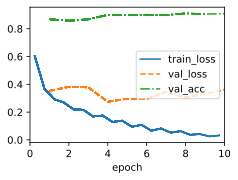

In [8]:
model = ResNet34(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

### Q3:

implementing the bottle neck architecture

assuming we are getting 256 dimensions: 

first 1x1 conv : 256dim to 64 dim

second 3x3 conv : 64dim to 64 dim

third 1x1 conv : 64 dim to 256 dim , add the input here before applying relu

using gpu : time = 4min only

In [17]:
#@title Residual Block with Bottle Neck
class Residual_BN(nn.Module):

  def __init__(self, num_channels=256, use_1x1conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.LazyConv2d(num_channels // 4, kernel_size=1, stride=strides)
    self.conv2 = nn.LazyConv2d(num_channels // 4, kernel_size=3, padding=1)
    self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1)

    if use_1x1conv:
      self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
    else:
      self.conv4 = None
    self.bn1 = nn.LazyBatchNorm2d()
    self.bn2 = nn.LazyBatchNorm2d()
    self.bn3 = nn.LazyBatchNorm2d()

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = F.relu(self.bn2(self.conv2(Y)))
    Y = self.bn3(self.conv3(Y))

    if self.conv4 is not None:
      X = self.conv4(X)
    return F.relu(Y+X)

In [20]:
blk = Residual_BN(use_1x1conv=True, strides=2)
X = torch.randn(4, 256, 96, 96)
blk(X).shape

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 256, 48, 48])

In [18]:
#@title ResNet with bottleneck block
class ResNet_BN(d2l.Classifier):

  def __init__(self, arch, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())

    for i, b in enumerate(arch):
      self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module("last", nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                              nn.Flatten(),
                                              nn.LazyLinear(num_classes)))
    
    self.net.apply(d2l.init_cnn)


  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=7, padding=3, stride=2),
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
    )

  def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
      if i == 0 and not first_block:
        blk.append(Residual_BN(num_channels, use_1x1conv=True, strides=2))
      else:
        blk.append(Residual_BN(num_channels))
    return nn.Sequential(*blk)

In [19]:
#@title ResNet18 with bottle neck
class ResNet18_BN(ResNet_BN):

  def __init__(self, lr=0.1, num_classes=10):
    arch = ((2, 64), (2, 128), (2, 256), (2, 512))
    super().__init__(arch, lr, num_classes)

  def forward(self, X):
    return self.net(X)

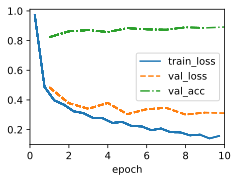

In [21]:
model = ResNet18_BN(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)